In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [219]:
# Import data
with open("./data/ftir_scan_OPA1.json", 'r') as json_file:
    ftir1 = json.load(json_file)

with open("./data/ftir_scan_OPA2.json", 'r') as json_file:
    ftir2 = json.load(json_file)

with open("./data/ftir_scan_OPA3.json", 'r') as json_file:
    ftir3 = json.load(json_file)

with open("./data/ftir_scan_OPA4.json", 'r') as json_file:
    ftir4 = json.load(json_file)

with open("./data/ftir_scan_OPA5.json", 'r') as json_file:
    ftir5 = json.load(json_file)

# Extract Interferogram and motor positions
motor_positions_1 = ftir1['motor positions']
interferogram_1 = ftir1['spectrogram']

motor_positions_2 = ftir2['motor positions']
interferogram_2 = ftir2['spectrogram']

motor_positions_3 = ftir3['motor positions']
interferogram_3 = ftir3['spectrogram']

motor_positions_4 = ftir4['motor positions']
interferogram_4 = ftir4['spectrogram']

motor_positions_5 = ftir5['motor positions']
interferogram_5 = ftir5['spectrogram']

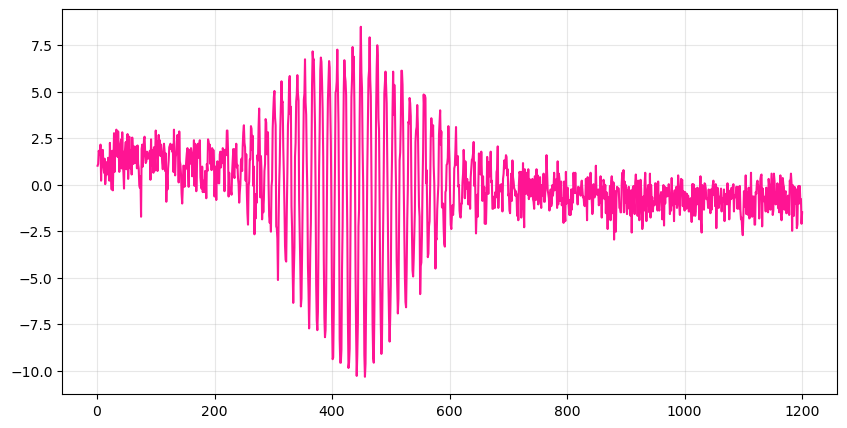

In [220]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(motor_positions_5, np.array(interferogram_5) - np.average(np.array(interferogram_5)), color='deeppink')
plt.grid(True, alpha=0.3)
plt.show()

In [225]:
# if the interferogram is even pad it to center the zpd
padded_interferogram = np.append(interferogram_5, np.average(interferogram_5))

# Now shift the zpd to the middle
zpd_index = np.argmax(padded_interferogram)
shifted_interferogram = np.roll(padded_interferogram, len(padded_interferogram)//2 - zpd_index)
zpd_index_new = np.argmax(shifted_interferogram)

# Make a new centered motor positions axis
step_interval = 1
shifted_steps = np.arange(0, len(motor_positions_5) + 1, step_interval)
shifted_steps = shifted_steps - shifted_steps[zpd_index_new]

# Shift interferogram down by average
shifted_interferogram = shifted_interferogram - np.average(shifted_interferogram)

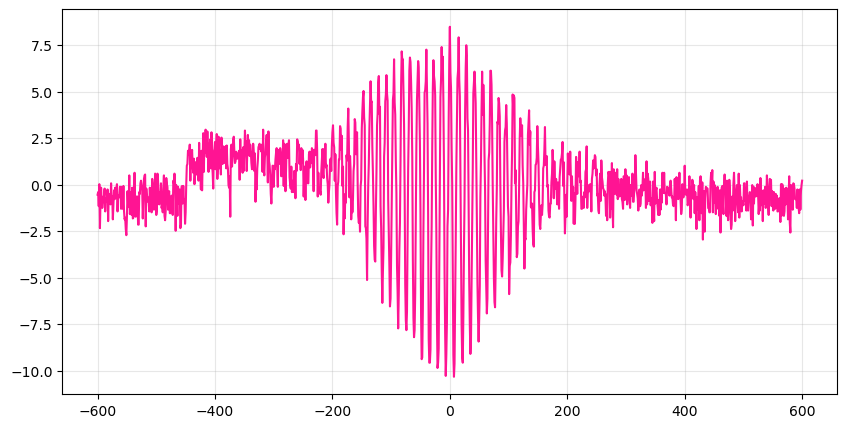

In [222]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(shifted_steps, shifted_interferogram, color='deeppink')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
window = np.hamming(len(shifted_interferogram),)
windowed_interferogram = shifted_interferogram * window

drop = 150
windowed_interferogram = windowed_interferogram[drop:-drop]
shifted_steps = shifted_steps[drop:-drop]

# Unwrap
# Unwrap - rearrange so it starts from the maximum
zpd_index = np.argmax(windowed_interferogram)
unwrapped_interferogram = np.concatenate([
    windowed_interferogram[zpd_index:],  # From max to end
    windowed_interferogram[:zpd_index]   # From start to max
])

# Also unwrap the corresponding steps
unwrapped_steps = np.concatenate([
    shifted_steps[zpd_index:],
    shifted_steps[:zpd_index]
])

normalized_interferogram = windowed_interferogram / np.max(np.abs(windowed_interferogram))


In [253]:
from scipy.signal import find_peaks

# Find the ZPD index (maximum peak)
zpd_index = np.argmax(windowed_interferogram)

# Find all peaks in the interferogram
peaks, _ = find_peaks(windowed_interferogram, height=0.1*np.max(windowed_interferogram))

# Find the next 10 peaks to the right of ZPD
next_10_peaks = []
for peak in peaks:
    if peak > zpd_index:
        next_10_peaks.append(peak)
        if len(next_10_peaks) == 10:
            break

if len(next_10_peaks) > 0:
    print(f"ZPD at index: {zpd_index}")
    
    # First peak - show distance from ZPD
    print(f"Peak 1 at index: {next_10_peaks[0]}, distance from ZPD: {next_10_peaks[0] - zpd_index} indices")
    
    # Subsequent peaks - show distance from previous peak
    for i in range(1, len(next_10_peaks)):
        peak_index = next_10_peaks[i]
        prev_peak_index = next_10_peaks[i-1]
        distance_from_prev = peak_index - prev_peak_index
        print(f"Peak {i+1} at index: {peak_index}, distance from previous peak: {distance_from_prev} indices")
else:
    print("No peaks found to the right of ZPD")


ZPD at index: 450
Peak 1 at index: 465, distance from ZPD: 15 indices
Peak 2 at index: 478, distance from previous peak: 13 indices
Peak 3 at index: 492, distance from previous peak: 14 indices
Peak 4 at index: 505, distance from previous peak: 13 indices
Peak 5 at index: 507, distance from previous peak: 2 indices
Peak 6 at index: 519, distance from previous peak: 12 indices
Peak 7 at index: 531, distance from previous peak: 12 indices
Peak 8 at index: 533, distance from previous peak: 2 indices
Peak 9 at index: 546, distance from previous peak: 13 indices
Peak 10 at index: 557, distance from previous peak: 11 indices


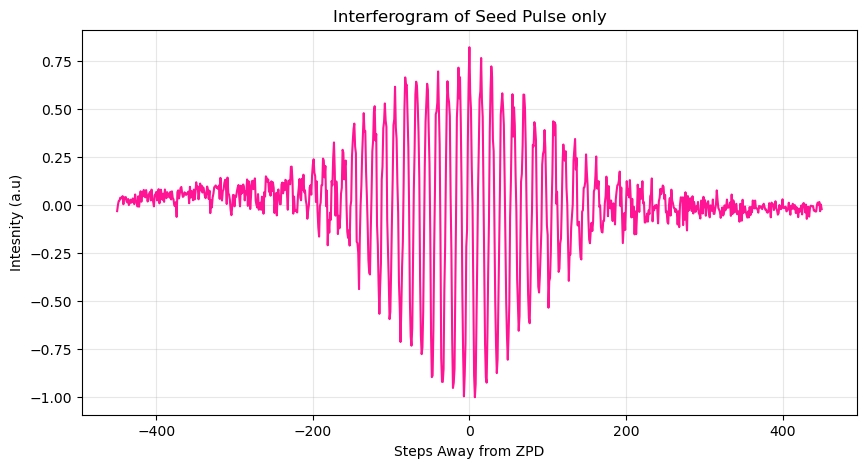

In [246]:
# Plot
plt.figure(figsize=(10,5))
plt.plot(shifted_steps, normalized_interferogram, color='deeppink')
plt.grid(True, alpha=0.3)
plt.xlabel("Steps Away from ZPD")
plt.ylabel("Intesnity (a.u)")
plt.title("Interferogram of Seed Pulse only")
plt.show()

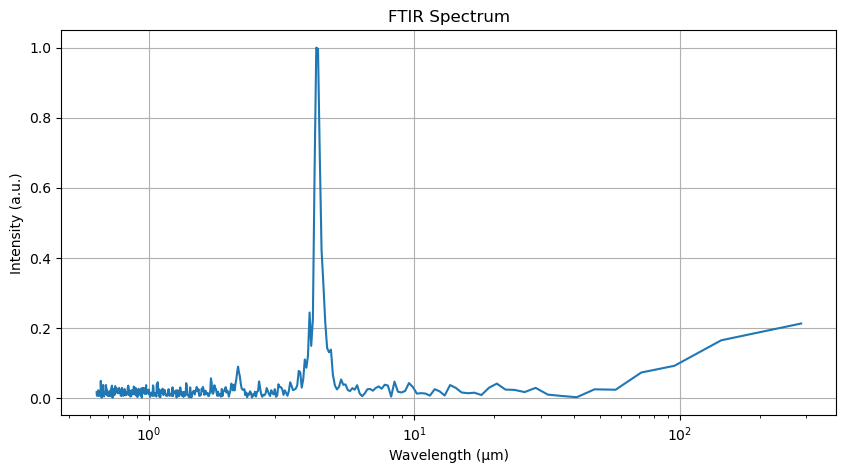

In [258]:
position_step = 318e-9  # m
N = len(normalized_interferogram)  # Use the actual data length
spatial_sampling_rate = 1 / position_step # samples per meter

# Use numpy's built-in frequency functions for accuracy
magnitude = np.abs(np.fft.rfft(normalized_interferogram))
spatial_f = np.fft.rfftfreq(N, d=position_step,)  # cycles/m

# Remove DC component and convert to wavelength
# spatial_f is in cycles/m, so wavelength = 1/spatial_f (in meters)
# Then convert to micrometers by multiplying by 1e6
wavelength_um = 1e6 / (spatial_f[1:])  # Factor of 2 for optical path difference
magnitude_no_dc = magnitude[1:]  # Remove DC component

plt.figure(figsize=(10, 5))
plt.plot(wavelength_um, magnitude_no_dc/ np.max(magnitude_no_dc))
plt.xlabel("Wavelength (μm)")
plt.ylabel("Intensity (a.u.)")
plt.title("FTIR Spectrum")
plt.xscale('log')
# plt.yscale('log')
plt.grid(True)
plt.show()

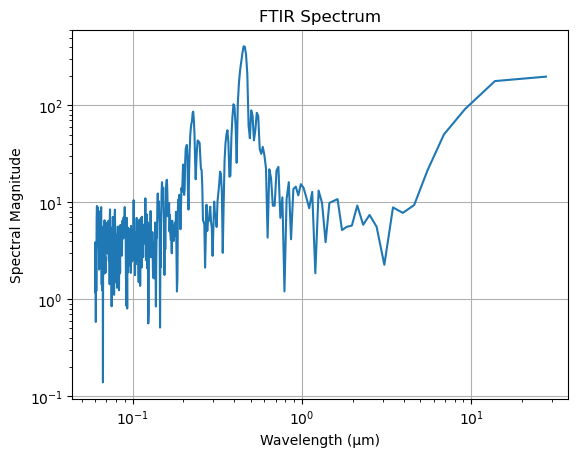

In [200]:
position_step = 30e-9  # m
N = len(windowed_interferogram)
spatial_sampling_rate = 1 / position_step # samples per meter

# For real FFT, we only get positive frequencies
# Use rfft for real-valued signals to avoid mirroring
magnitude = np.abs(np.fft.rfft(windowed_interferogram))

# Create frequency axis that matches the rfft output
spatial_f = np.fft.rfftfreq(N, d=position_step)  # cycles/m

# Convert wavenumber (1/m) to wavelength (μm)
# Avoid division by zero by excluding the DC component (first element)
wavelength_um = 1e6 / spatial_f[1:]  # Convert to micrometers
magnitude_no_dc = magnitude[1:]  # Remove DC component

plt.plot(wavelength_um, magnitude_no_dc)
plt.xlabel("Wavelength (μm)")
plt.xscale('log')
plt.yscale('log')  # Set y-axis to log scale
plt.ylabel("Spectral Magnitude")
plt.title("FTIR Spectrum")
plt.grid(True)
plt.show()